In [1]:
import os
import json
import csv
import math
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def calculateLAE(a,b):
    return math.log2(abs(a-b)*100+0.125)

def calculateMLAE(predict_list,true_list):
    lae=[]
    for i in range(len(predict_list)):
        sum_=0
        lossTotal=0
        for j in range(len(predict_list[i])):
            lossTotal+=1
            sum_+=calculateLAE(predict_list[i][j],true_list[i][j])
        lae.append(sum_/lossTotal)
#     sorted_lae=sorted(lae)
#     quarter=len(sorted_lae)//4
#     data=sorted_lae[quarter:-quarter]
    avg=np.mean(lae)
    return lae
def compute_sum(data):
    sum=0
    for i in data:
        sum+=i
    return sum

def average(data):
    return sum(data) / len(data)
def bootstrap(data, B, c, func):

    array = np.array(data)
    n = len(array)
    sample_result_arr = []
    for i in range(B):
        # index_arr = np.random.randint(0, n, size=n)
        index_arr = np.random.choice(array, n)
        # print(index_arr)
        # data_sample = array[index_arr]
        data_sample = index_arr
        if func=="average":
            sample_result = average(data_sample)
        if func=="std":
            sample_result = np.std(data_sample)
        if func=="0.025":
            data_sample=sorted(data_sample)
            sample_result = data_sample[math.ceil(n*0.05)-1]
        if func=="0.975":
            data_sample=sorted(data_sample)
            sample_result = data_sample[int(n*0.95)-1]
        sample_result_arr.append(sample_result)

    a = 1 - c
    k1 = int(B * a / 2)
    k2 = int(B * (1 - a / 2))
    auc_sample_arr_sorted = sorted(sample_result_arr)
    lower = auc_sample_arr_sorted[k1]
    higher = auc_sample_arr_sorted[k2]

    # return lower, higher
    # print(lower, higher)
    # print((lower+higher)/2)
    # return auc_sample_arr_sorted
    return (lower+higher)/2,higher-(lower+higher)/2

find_float = lambda x: re.search("\d+(\.\d+)?",x).group()

In [13]:
typeToName={'posLen_tp_1_rand_c':'bar_type1_%d.json',
            'posLen_tp_2_rand_c':'stack_type2_%d.json',
            'posLen_tp_3_rand_c':'bar_type3_%d.json',
            'posLen_tp_4_rand_c':'stack_type2_%d.json',
            'posLen_tp_5_rand_c':'stack_type2_%d.json'}
tasks=['posLen_tp_1_rand_c',
        'posLen_tp_2_rand_c','posLen_tp_3_rand_c',
        'posLen_tp_4_rand_c','posLen_tp_5_rand_c']

user_order={'posLen_tp_1_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                                  'Bar color','Bar length','dot position'],
            'posLen_tp_2_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                           'Bar color','Bar length','dot position'],
      'posLen_tp_3_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                           'Bar color','Bar length','dot position'],
            'posLen_tp_4_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                           'Bar color','Bar length','dot position'],
           'posLen_tp_5_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                                 'Bar color','Bar length','dot position']}

cnn_order={'posLen_tp_1_rand_c':[0,1,2,3,4,5,6,7,8],
           'posLen_tp_2_rand_c':[0,1,2,3,4,5,6,7,8],
      'posLen_tp_3_rand_c':[0,1,2,3,4,5,6,7,8],
        'posLen_tp_4_rand_c':[0,1,2,3,4,5,6,7,8],
           'posLen_tp_5_rand_c':[0,1,2,3,4,5,6,7,8]}

cnn_order_name={'posLen_tp_1_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                                     'Bar color','Bar length','dot position'],
                'posLen_tp_2_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                           'Bar color','Bar length','dot position'],
      'posLen_tp_3_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                           'Bar color','Bar length','dot position'],
           'posLen_tp_4_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                                 'Bar color','Bar length','dot position'],
           'posLen_tp_5_rand_c':['Standard','Title position','Stroke width','Bar width','Bkgd color','Stroke color',
                                 'Bar color','Bar length','dot position']}


In [14]:

cnn_color=tuple([i/255 for i in [236,201,73]])
human_color=tuple([i/255 for i in [177,122,162]])

ALL_human={}
human_deviation={}
cnn_deviation={}

for task in tasks:
    
    human_deviation[task]={}
    cnn_deviation[task]={}
    predict_value={}
    true_value={}
    cnn_predict_value={}
    cnn_true_value={}
    userstudy=user_order[task]
    cnnstudy=cnn_order_name[task]
    for i in userstudy:
        predict_value[i]=[]
        true_value[i]=[]
        cnn_predict_value[i]=[]
        cnn_true_value[i]=[]

    path='./human_2/human_2/'
    dataNmae=task
    true_value_path='../test_result_4/dataset/%s_testdata_%d/valid/target/'
    cnnPath='../test_result_4/raw_result/resnet152_%s_lw/final_3/' % dataNmae
    iterName=int(re.findall('\d+',os.listdir(cnnPath)[0])[-1])

    allfile=[i for i in os.listdir(path) if dataNmae in i.split("-") and 'add' not in i]
    for file in allfile:
        namePath=path+file
        with open(namePath) as f:
            f_csv=csv.reader(f)
            header=next(f_csv)
            for row in f_csv:
                with open(true_value_path % (dataNmae,int(row[2]))+typeToName[dataNmae] % int(row[3]),'r') as f_:
                    d=json.load(f_)
                    true_value[userstudy[int(row[2])]].append(d)
                if 'posAngle' in task:
                    g=[]
                    for ii in range(4,8):
                        g.append(float(find_float(row[ii])))
                    predict_value[userstudy[int(row[2])]].append(g)
                    pass
                else:
                    predict_value[userstudy[int(row[2])]].append([float(row[4])])

    ALL_human[task]=predict_value

        
    #cnn
    for index in range(len(cnn_order[dataNmae])):
        cnn_infoPath='../test_result_4/raw_result/resnet152_%s_lw/final_3/%s_human_testdata_%d_Iter_%d_result.json' % (dataNmae,dataNmae,cnn_order[dataNmae][index],iterName)
        with open(cnn_infoPath,'r') as ff:
            d=json.load(ff)
            cnn_predict_value[cnnstudy[index]]=d['predict']
            cnn_true_value[cnnstudy[index]]=d['true']
        mlae_cnn=calculateMLAE(cnn_predict_value[userstudy[index]],cnn_true_value[userstudy[index]])
    count=0
#     fig=plt.figure(figsize=(7,5))
    for k in cnnstudy:
        count+=1
        mlae=calculateMLAE(predict_value[k],true_value[k])
        mlae_cnn=calculateMLAE(cnn_predict_value[k],cnn_true_value[k])
        if k!='Standard':
            human_deviation[task][k]=[abs(mlae[ix]-human_deviation[task]['Standard'][ix]) for ix in range(len(mlae))]
            cnn_deviation[task][k]=[abs(mlae_cnn[ix]-cnn_deviation[task]['Standard'][ix]) for ix in range(len(mlae_cnn))]
        else:
            human_deviation[task][k]=mlae
            cnn_deviation[task][k]=mlae_cnn

In [15]:
param_dev={
    'Title position':[],
    'Stroke width':[],
    'Bar width':[],
    'Bkgd color':[],
    'Stroke color':[],
    'Bar color':[],
    'Bar length':[],
    'dot position':[]
}
cnn_param_dev={
    'Title position':[],
    'Stroke width':[],
    'Bar width':[],
    'Bkgd color':[],
    'Stroke color':[],
    'Bar color':[],
    'Bar length':[],
    'dot position':[]
}
for task,param_mlaedev in human_deviation.items():
    for param,mlaedev in param_mlaedev.items():
        if param=='Standard':
            continue
        param_dev[param]+=mlaedev
        cnn_param_dev[param]+=cnn_deviation[task][param]

In [16]:
for param,dev in param_dev.items():
    print(param)
    res=stats.levene(dev,param_dev['Title position'])
    statistic,pvalue=res
    if pvalue>0.05:
        T_statistic,T_pvalue=stats.ttest_ind(dev,param_dev['Title position'],equal_var=True)
    else:
        T_statistic,T_pvalue=stats.ttest_ind(dev,param_dev['Title position'],equal_var=False)
    print('T_pvalue: ',T_pvalue)
print("=====================")
for param,dev in cnn_param_dev.items():
    print(param)
    res=stats.levene(dev,cnn_param_dev['Title position'])
    statistic,pvalue=res
    if pvalue>0.05:
        T_statistic,T_pvalue=stats.ttest_ind(dev,cnn_param_dev['Title position'],equal_var=True)
    else:
        T_statistic,T_pvalue=stats.ttest_ind(dev,cnn_param_dev['Title position'],equal_var=False)
    print('T_pvalue: ',T_pvalue)
print("=====================")
for param,dev in param_dev.items():
    print(param)
    res=stats.levene(dev,cnn_param_dev[param])
    statistic,pvalue=res
    if pvalue>0.05:
        T_statistic,T_pvalue=stats.ttest_ind(dev,cnn_param_dev[param],equal_var=True)
    else:
        T_statistic,T_pvalue=stats.ttest_ind(dev,cnn_param_dev[param],equal_var=False)
    print('T_pvalue: ',T_pvalue)

Title position
T_pvalue:  1.0
Stroke width
T_pvalue:  0.42490658427948436
Bar width
T_pvalue:  0.8782860251229763
Bkgd color
T_pvalue:  0.725079098193101
Stroke color
T_pvalue:  0.6166958779900824
Bar color
T_pvalue:  0.27140523365906194
Bar length
T_pvalue:  0.2668842631243548
dot position
T_pvalue:  0.10168927755946916
Title position
T_pvalue:  1.0
Stroke width
T_pvalue:  1.9397888221235688e-41
Bar width
T_pvalue:  3.916037787414734e-197
Bkgd color
T_pvalue:  0.0
Stroke color
T_pvalue:  0.004108845746475293
Bar color
T_pvalue:  1.3658650580666967e-21
Bar length
T_pvalue:  0.0
dot position
T_pvalue:  3.256234562902546e-182
Title position
T_pvalue:  2.561229648842129e-05
Stroke width
T_pvalue:  3.922601235315045e-29
Bar width
T_pvalue:  9.59141866348383e-74
Bkgd color
T_pvalue:  7.724917647131306e-175
Stroke color
T_pvalue:  5.594827214821314e-07
Bar color
T_pvalue:  2.4402601697960333e-29
Bar length
T_pvalue:  2.511977300393858e-134
dot position
T_pvalue:  9.195820513982743e-84


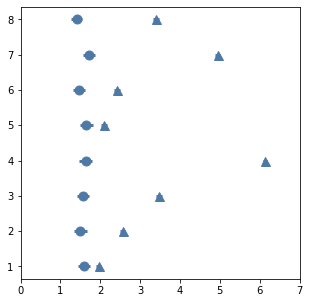

In [17]:
ks=[]
fig=plt.figure(figsize=(5,5))
tasks_shape_color={
    'posLen_tp_1_rand_c':['o','#F28E2C'],
    'posLen_tp_2_rand_c':['+','#E15659'],
    'posLen_tp_3_rand_c':['^','#59A14F'],
    'posLen_tp_4_rand_c':['x','#76B7AF'],
    'posLen_tp_5_rand_c':['*','#4E79A6'],
}
i=0
for param,mlaedev in param_dev.items():
    i+=1
    mean_user,confidence_user = bootstrap(mlaedev, 10000, 0.95, "average")
    mean_cnn,confidence_cnn = bootstrap(cnn_param_dev[param], 10000, 0.95, "average")
    y_cnn=[mean_cnn]
    x_cnn=i
    y_user=[mean_user]
    x_user=i
    line1=plt.errorbar(y_cnn,x_cnn,xerr=confidence_cnn,fmt='^',elinewidth=3,label='CNN',color=tasks_shape_color[task][1],ms=9)
    line2=plt.errorbar(y_user,x_user,xerr=confidence_user,fmt='o',elinewidth=3,ecolor=tasks_shape_color[task][1],color=tasks_shape_color[task][1],ms=9)
plt.xticks(range(0,8))
plt.savefig(os.path.join('./fig_results','mlae_deviation_eight_param.svg'),bbox_inches = 'tight')
plt.show()